
--- Sorting Performance Comparison ---

Benchmarking n=100 ...
Benchmarking n=500 ...
Benchmarking n=1000 ...
Benchmarking n=5000 ...
Benchmarking n=10000 ...

Averaged over 3 trials:
Size    Bubble Sort Quick Sort  Merge Sort  Heap Sort   
--------------------------------------------------------
100     0.000167    0.000074    0.000059    0.000063    
500     0.004494    0.000406    0.000366    0.000438    
1000    0.020778    0.000857    0.000831    0.001031    
5000    0.513638    0.004380    0.004884    0.006200    
10000   N/A         0.009028    0.010566    0.013726    


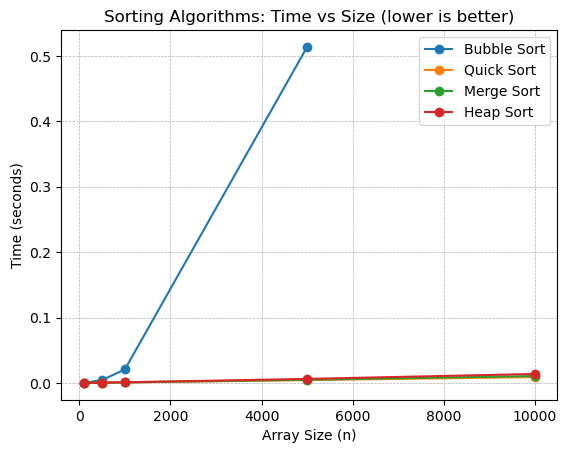

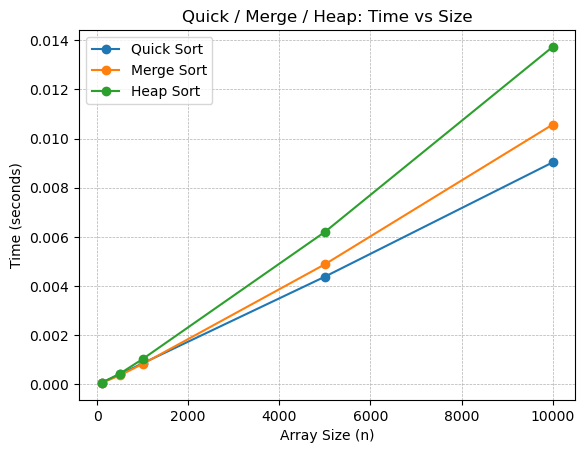

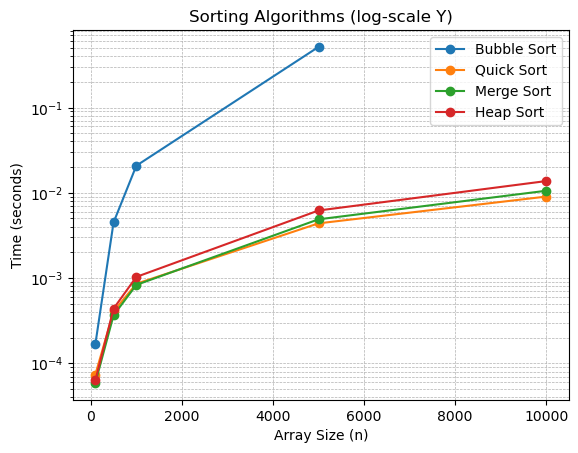


Saved figures:
  - plot_all_algorithms.png
  - plot_no_bubble.png
  - plot_log_scale.png


In [11]:
import random
import time
import math
import matplotlib.pyplot as plt

# -------------------------------
# Sorting implementations
# -------------------------------

def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        # после каждой итерации i последний элемент уже на месте
        for j in range(0, n - i - 1):
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]


def _partition_hoare_random_pivot(arr, low, high):
    # pivot — случайное значение из диапазона
    pivot = arr[random.randint(low, high)]
    i, j = low, high
    while i <= j:
        while arr[i] < pivot:
            i += 1
        while arr[j] > pivot:
            j -= 1
        if i <= j:
            arr[i], arr[j] = arr[j], arr[i]
            i += 1
            j -= 1
    return i  # правая граница левого подмассива + 1


def quick_sort(arr, low, high):
    if low < high:
        p = _partition_hoare_random_pivot(arr, low, high)
        quick_sort(arr, low, p - 1)
        quick_sort(arr, p, high)


def _merge(arr, l, m, r):
    left = arr[l:m + 1]
    right = arr[m + 1:r + 1]
    i = j = 0
    k = l
    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            arr[k] = left[i]
            i += 1
        else:
            arr[k] = right[j]
            j += 1
        k += 1
    while i < len(left):
        arr[k] = left[i]
        i += 1
        k += 1
    while j < len(right):
        arr[k] = right[j]
        j += 1
        k += 1


def merge_sort(arr, l, r):
    if l < r:
        m = l + (r - l) // 2
        merge_sort(arr, l, m)
        merge_sort(arr, m + 1, r)
        _merge(arr, l, m, r)


def _heapify(arr, n, i):
    largest = i
    l = 2 * i + 1
    r = 2 * i + 2
    if l < n and arr[l] > arr[largest]:
        largest = l
    if r < n and arr[r] > arr[largest]:
        largest = r
    if largest != i:
        arr[i], arr[largest] = arr[largest], arr[i]
        _heapify(arr, n, largest)


def heap_sort(arr):
    n = len(arr)
    # построение max-heap
    for i in range(n // 2 - 1, -1, -1):
        _heapify(arr, n, i)
    # извлечение максимумов
    for i in range(n - 1, 0, -1):
        arr[0], arr[i] = arr[i], arr[0]
        _heapify(arr, i, 0)

# -------------------------------
# Benchmarking helpers
# -------------------------------

def time_function(sort_callable, arr, trials=3):
    """Вернёт среднее время выполнения sort_callable(arr_copy) по trials прогонам."""
    times = []
    for _ in range(trials):
        data = arr[:]  # копия исходного массива
        start = time.perf_counter()
        sort_callable(data)
        end = time.perf_counter()
        times.append(end - start)
    return sum(times) / len(times)


def print_table(results, sizes, algo_names):
    """Красивый вывод таблицы времени."""
    # header
    colw = 12
    header = "Size".ljust(8) + "".join(name.ljust(colw) for name in algo_names)
    print(header)
    print("-" * len(header))
    for n in sizes:
        row = str(n).ljust(8)
        for name in algo_names:
            t = results.get((n, name))
            cell = "N/A" if t is None else f"{t:.6f}"
            row += cell.ljust(colw)
        print(row)


def plot_lines(results, sizes, algo_names, title, filename=None, logy=False, exclude=None):
    """Линейный график: время vs размер массива."""
    plt.figure()
    for name in algo_names:
        if exclude and name in exclude:
            continue
        y = []
        for n in sizes:
            t = results.get((n, name))
            y.append(t)
        plt.plot(sizes, y, marker='o', label=name)
    plt.title(title)
    plt.xlabel("Array Size (n)")
    plt.ylabel("Time (seconds)")
    if logy:
        plt.yscale("log")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    if filename:
        plt.savefig(filename, bbox_inches="tight", dpi=160)
    plt.show()

# -------------------------------
# Main benchmarking
# -------------------------------

if __name__ == "__main__":
    random.seed(int(time.time()))

    SIZES = [100, 500, 1000, 5000, 10000]
    TRIALS = 3
    BUBBLE_MAX = 5000  # чтобы не зависнуть на 10000

    # Обёртки с сигнатурой func(arr) для бенчмарка
    algorithms = {
        "Bubble Sort": lambda a: bubble_sort(a),
        "Quick Sort":  lambda a: quick_sort(a, 0, len(a) - 1),
        "Merge Sort":  lambda a: merge_sort(a, 0, len(a) - 1),
        "Heap Sort":   lambda a: heap_sort(a),
    }

    print("\n--- Sorting Performance Comparison ---\n")

    # (n, name) -> avg_time
    results = {}

    for n in SIZES:
        base = [random.randint(0, 10000) for _ in range(n)]
        print(f"Benchmarking n={n} ...")

        for name, fn in algorithms.items():
            if name == "Bubble Sort" and n > BUBBLE_MAX:
                results[(n, name)] = None
                continue
            avg_time = time_function(fn, base, trials=TRIALS)
            results[(n, name)] = avg_time

    print("\nAveraged over", TRIALS, "trials:")
    algo_names = list(algorithms.keys())
    print_table(results, SIZES, algo_names)

    # -------------------------------
    # Plots
    # -------------------------------
    # 1) общий график
    plot_lines(
        results, SIZES, algo_names,
        title="Sorting Algorithms: Time vs Size (lower is better)",
        filename="plot_all_algorithms.png"
    )

    # 2) без Bubble Sort — для читабельности
    plot_lines(
        results, SIZES, algo_names,
        title="Quick / Merge / Heap: Time vs Size",
        filename="plot_no_bubble.png",
        exclude={"Bubble Sort"}
    )

    # 3) лог-шкала
    plot_lines(
        results, SIZES, algo_names,
        title="Sorting Algorithms (log-scale Y)",
        filename="plot_log_scale.png",
        logy=True
    )

    print("\nSaved figures:")
    print("  - plot_all_algorithms.png")
    print("  - plot_no_bubble.png")
    print("  - plot_log_scale.png")
